#### Directories etc

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
from collections import defaultdict
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from random import sample
pd.options.mode.chained_assignment = None  # default='warn'
import ete3;

C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
project_dir = 'F:/Project_Data/Project_9'
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
dictionary_dir = 'F:/Datasets/CRYPTIC_DATA/Cryptic_Dictionaries'
mutation_count_dir = 'F:/Datasets/CRYPTIC_DATA/Cryptic_Mutation_Counts'
mutation_count_dir = 'F:/Datasets/CRYPTIC_DATA/Cryptic_Mutation_Counts'
tree_dir = 'F:/Datasets'
tb_species = 'NC_000962.3' 
tb_genome_filename = 'GCF_000195955.2_ASM19595v2_genomic.gbff'
mycobrowser_dir = 'F:/Datasets/Data_From_Publications'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [3]:
for record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    full_sequence = str(record.seq)
    tb_sequence = str(record.seq)
for record in SeqIO.parse(project_dir + '/annot.gbk', "genbank"):
    reannotated_sequence = str(record.seq)

In [4]:
mycobrowser_features =[]
mycobrowser_df = pd.read_csv(mycobrowser_dir+'/Mycobrowser_Release_4.csv')
for i, r in mycobrowser_df.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    mycobrowser_features.append([r['Feature'], r['Locus'],r['Start']-1, r['Stop'], strand, r['Product'], r['Comments']])

In [5]:
full_run = False

#### Functions

In [6]:
def bin_formula(position_3_counts, tot_bin_counts):
    return 1- binom.cdf(position_3_counts-1, tot_bin_counts,1/3)

In [7]:
def mutation_bin_probability(mutation_counts):
    bin_counts = [0,0,0]
    for i, c in enumerate(mutation_counts):
        bin_counts[i % 3] += c
    if sum(bin_counts) == 0:
        return (bin_counts, 2)
    else:
        return (bin_counts, bin_formula(bin_counts[2], sum(bin_counts)))  

In [8]:
master_tree= ete3.Tree(tree_dir + '/' + 'tb_tree.nwk')

In [9]:
len(master_tree)

71054

#### Calculate probabilites for annotated (and reannotated PGAP) CDS regions

In [10]:
cds_boundaries = []
for genome_record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    for feature in genome_record.features:
        if feature.type == 'CDS':
            a = feature.qualifiers  
            if a.get("pseudo") == None:
                pseudo = False
            else:
                pseudo = True
            cds_boundaries.append((a.get("locus_tag")[0], pseudo, a.get("product")[0], int(feature.location.start), int(feature.location.end), int(feature.location.strand)))   
reannotated_cds_boundaries = []
for genome_record in SeqIO.parse(project_dir + '/annot.gbk', "genbank"):
    for feature in genome_record.features:
        if feature.type == 'CDS':
            a = feature.qualifiers  
            if a.get("pseudo") == None:
                pseudo = False
            else:
                pseudo = True
            reannotated_cds_boundaries.append((a.get("locus_tag")[0], pseudo, a.get("product")[0], int(feature.location.start), int(feature.location.end), int(feature.location.strand)))   
cds_boundaries.sort(key = lambda x: x[3])
reannotated_cds_boundaries.sort(key = lambda x: x[3])

In [16]:
mutation_df = pd.read_csv(project_dir+'/mutation_df.csv')
alt_mutation_df = pd.read_csv(project_dir+'/alt_mutation_df.csv')
gpi_mutation_df = pd.read_csv(project_dir+'/gpi_mutation_df.csv')

In [17]:
zero_and_non_zero_mutation_counts = mutation_df['Num_Mutations'].values.tolist()
alt_zero_and_non_zero_mutation_counts = alt_mutation_df['Num_Mutations'].values.tolist()
gpi_zero_and_non_zero_mutation_counts = gpi_mutation_df['Num_Mutations'].values.tolist()

In [18]:
with open(project_dir + '/alt_mutation_counts.pkl', 'wb') as f:
        pickle.dump(alt_zero_and_non_zero_mutation_counts, f) 
with open(project_dir + '/gpi_mutation_counts.pkl', 'wb') as f:
        pickle.dump(gpi_zero_and_non_zero_mutation_counts, f) 

In [19]:
temp =[]
alt_temp = []
gpi_temp = []
alt_locus_mutation = []
gpi_locus_mutation = []
for (locus, pseudo, product, start, stop, strand) in cds_boundaries:
    if pseudo == False:
        if strand == 1:
            temp.append(mutation_bin_probability(zero_and_non_zero_mutation_counts[start:stop]))
            alt_temp.append(mutation_bin_probability(alt_zero_and_non_zero_mutation_counts[start:stop]))
            gpi_temp.append(mutation_bin_probability(gpi_zero_and_non_zero_mutation_counts[start:stop]))
            alt_locus_mutation.append([locus, mutation_bin_probability(alt_zero_and_non_zero_mutation_counts[start:stop])[1]])
            gpi_locus_mutation.append([locus, mutation_bin_probability(gpi_zero_and_non_zero_mutation_counts[start:stop])[1]])
        else:
            temp.append(mutation_bin_probability(reversed(zero_and_non_zero_mutation_counts[start:stop])))
            alt_temp.append(mutation_bin_probability(reversed(alt_zero_and_non_zero_mutation_counts[start:stop])))
            gpi_temp.append(mutation_bin_probability(reversed(alt_zero_and_non_zero_mutation_counts[start:stop])))
            alt_locus_mutation.append([locus, mutation_bin_probability(reversed(alt_zero_and_non_zero_mutation_counts[start:stop]))[1]])
            gpi_locus_mutation.append([locus, mutation_bin_probability(reversed(gpi_zero_and_non_zero_mutation_counts[start:stop]))[1]])
scores = []
for x in temp:
    scores.append(x[1])
alt_scores = []
for x in alt_temp:
    alt_scores.append(x[1])
gpi_scores = []
for x in gpi_temp:
    gpi_scores.append(x[1])

<AxesSubplot:ylabel='Count'>

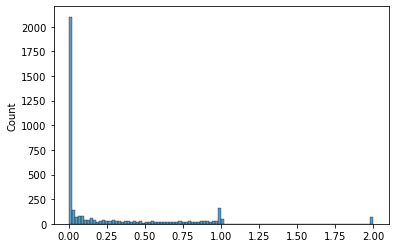

In [21]:
sns.histplot(gpi_scores, bins =100)

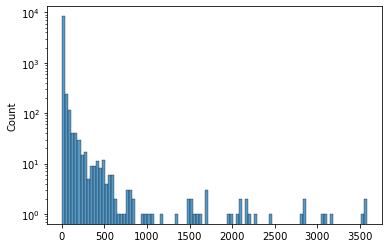

In [22]:
sns.histplot([x for x in gpi_zero_and_non_zero_mutation_counts if x >3], bins = 100)
plt.yscale('log')

In [23]:
for n, c in enumerate(gpi_zero_and_non_zero_mutation_counts):
    if c > 3000:
        print(n, c)

132416 3156
454294 3542
837032 3084
1224366 3579
2509139 3051
3186859 3547


In [ ]:
sum(zero_and_non_zero_mutation_counts)/len(zero_and_non_zero_mutation_counts)

In [ ]:
sns.histplot([x for x in zero_and_non_zero_mutation_counts if (x > 250)], bins = 100)

In [ ]:
if full_run == False:
    with open(project_dir + '/id_dict.pkl', 'rb') as f:
        id_dict = pickle.load(f)  
    with open(project_dir + '/variant_dict.pkl', 'rb') as f:
        variant_dict = pickle.load(f)  
    with open(project_dir + '/position_dict.pkl', 'rb') as f:
        position_dict = pickle.load(f)  

In [ ]:
for n,pos in enumerate(alt_zero_and_non_zero_mutation_counts):
    if n+1 in position_dict:
        rat = pos/ len(position_dict[n+1])
        if pos == 0 and len(position_dict[n+1]) > 0:
            print(n,pos, len(position_dict[n+1]), rat)

#### Identify potential ORFS (min length 200) in inter-CDS regions of standard annotation and output to Dataframe

In [ ]:
ORFFinder = orffn.ORF_Finder()
trans = util.Translator()
min_intergenic_length = 100
details =  []
results =[]
for i, (locus, pseudo, product, start, stop, strand) in enumerate(cds_boundaries):
    if i < len(cds_boundaries) - 1:
        if cds_boundaries[i+1][3] > stop + min_intergenic_length:
            a =ORFFinder.max_orf(stop-40, cds_boundaries[i+1][3]+40, 1e-20, output_all_orfs = False, min_orf_length = 200)
            if not(a==(0,0,0)):
                ov = 0
                info = ('','','','','','','')
                for i, (loc, pse, pro, sta, sto, stra) in enumerate(reannotated_cds_boundaries):
                    if a[1] > sta and a[0] < sto:
                        ov = (min(a[1], sto) - max(a[0], sta)) / (sto - sta)
                        if ov > 0.3:
                            info =  (loc, pse, pro, sta, sto, stra, ov)
                        
                ov = 0
                myco_info = ('','','','','')
                for i, (loc, sta, sto, stra) in enumerate(mycobrowser_features):
                    if a[1] > sta and a[0] < sto:
                        ov = (min(a[1], sto) - max(a[0], sta)) / (sto - sta)
                        if ov > 0.3:
                            myco_info =  (loc, sta, sto, stra, ov)
                        
                sequ = trans.translate_sequence(full_sequence[a[0]:a[1]], a[2], 0)
                details.append([a, sequ])
                results.append([a[0],a[1],a[2],a[3],info[0],info[1],info[2],info[3],info[4],info[5],info[6],myco_info[0],myco_info[1],myco_info[2],myco_info[3],myco_info[4]])
results_df = pd.DataFrame(results, columns = ['start_pos','end_pos','strand','score','PGAP_ref','PGAP_pseudogene','PGAP_product', 'PGAP_start', 'PGAP_end','PGAP_strand', 'PGAP_overlap', 'Mycob_ref','Mycob_start', 'Mycob_end','Mycob_strand', 'Mycob_overlap'])
results_df.to_csv(project_dir + '/cds_candidates.csv')

#### Find all (maximal nested) ORFs and filter out ORFS on opposite strand which would have same non-synonymous positions with larger ORF on other strand

In [ ]:
ORFFinder = orffn.ORF_Finder(full_sequence)
a = ORFFinder.max_orf(0, 4411532, output_orfs = 'Nested', min_orf_length = 50)
a.sort(key = lambda x: x[3], reverse = True)
orf_list = [a[0]]
for x in tqdm(a[1:]):
    matched = 0
    for v in orf_list:
        if v[0]<=x[0] and v[1]>=x[1]:
            if x[2] == v[2]:
                if (v[0] - x[0])%3 == 0:
                    matched = 1
                    break
            else:
                if (v[0] - x[0])%3 == 1:
                    matched = 1
                    break
    if matched == 0:
        orf_list.append(x)
orf_list.sort(key = lambda x: x[0])

In [ ]:
temp = []
for (start, stop, strand, length) in tqdm(orf_list):
    matches_annotated_orf = False
    for (locus_1, pseudo_1, product_1, start_1, stop_1, strand_1) in cds_boundaries:
        if (pseudo_1 == False and strand_1 == strand and strand_1 == 1 and stop_1 == stop) or (pseudo_1 == False and strand_1 == strand and strand_1 == -1 and start_1 == start):
            matches_annotated_orf = True
            break
    if matches_annotated_orf == True:
        continue
    if strand == 1:
        temp.append((mutation_bin_probability(alt_zero_and_non_zero_mutation_counts[start:stop]), stop-start))
    else:
        temp.append((mutation_bin_probability(reversed(alt_zero_and_non_zero_mutation_counts[start:stop])), stop-start))
scores = []
for (x, y) in temp:
    scores.append([x[1], y])
scores_df = pd.DataFrame(scores, columns = ['score','length'])

In [ ]:
ultra_conserved_candidates = []
lengths = []
mutation_len = len(alt_zero_and_non_zero_mutation_counts)
i = 0
start = 0
while i < mutation_len:
    if alt_zero_and_non_zero_mutation_counts[i] == 0:
        i+=1
    else:
        stop = i
        zero_length = stop - start - 1
        if zero_length > 150 or zero_length < 8:
            pass
        else:
            lengths.append(zero_length)
            ultra_conserved_candidates.append([start, stop])
        i+=1 
        start = i


In [ ]:
sns.histplot(data = lengths, bins = 100)

In [ ]:
temp = []
for x in ultra_conserved_candidates:
    sequence = tb_sequence[x[0]:x[1]]
    name = 'Start_'+str(x[0])+'_Stop_'+str(x[1])
    temp.append([name, sequence])
util.produce_fasta_file(temp, project_dir + '/' + 'ultra_conserved_candidates.faa')

In [ ]:
temp = []
for (feature, locus, start, stop, strand, product, comments) in mycobrowser_features:
    if feature == 'CDS':
        if strand == 1:
            sequence = tb_sequence[start:stop]
        else:
            sequence = util.reverse_complement(tb_sequence[start:stop])
        temp.append([locus, sequence])
util.produce_fasta_file(temp, project_dir + '/' + 'tb_cds.faa')

In [ ]:
sns.histplot(data = scores_df, x= 'score', bins =100)

In [ ]:
sns.scatterplot(data = scores_df, x = 'length', y ='score')

In [ ]:
prob = []
for x in orf_list:
    prob.append(x[4])
sns.histplot(prob, bins=100)

In [ ]:
annotated_features = []
for genome_record in SeqIO.parse(project_dir + '/annot.gbk', "genbank"):
    for feature in genome_record.features:
        if feature.type != 'source':
            annotated_features.append((int(feature.location.start), int(feature.location.end), int(feature.location.strand)))   
for genome_record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    for feature in genome_record.features:
        if feature.type != 'source':
            annotated_features.append((int(feature.location.start), int(feature.location.end), int(feature.location.strand)))   
annotated_features.sort(key = lambda x: x[1])

In [ ]:
non_overlapping_orfs = []
for i, orf in enumerate(orf_list):
    max_ov = 0
    for (sta, sto, stra) in annotated_features:
        if orf[0] < sto and orf[1] > sta:
            ov = (min(orf[1], sto) - max(orf[0], sta)) / (orf[1] - orf[0])
            max_ov = max(ov, max_ov)
    if max_ov < 0.1:
        non_overlapping_orfs.append(orf)

In [ ]:
non_overlapping_orf_list = []
temp = []
for (start, stop, strand, length) in tqdm(non_overlapping_orfs):
    if strand == 1:
        temp.append((mutation_bin_probability(alt_zero_and_non_zero_mutation_counts[start:stop]), stop-start))
        non_overlapping_orf_list.append((start, stop, strand, length, mutation_bin_probability(alt_zero_and_non_zero_mutation_counts[start:stop])))
    else:
        temp.append((mutation_bin_probability(reversed(alt_zero_and_non_zero_mutation_counts[start:stop])), stop-start))
        non_overlapping_orf_list.append((start, stop, strand, length,mutation_bin_probability(reversed(alt_zero_and_non_zero_mutation_counts[start:stop]))))
scores = []
for (x, y) in temp:
    scores.append([x[1], y])
scores_non_overlapping_df = pd.DataFrame(scores, columns = ['score','length'])

In [ ]:
sns.histplot(data = scores_non_overlapping_df, x= 'score', bins =100)

In [ ]:
sns.scatterplot(data = scores_non_overlapping_df, x = 'length', y ='score')

#### Produce FASTA file with CDS candidates

In [ ]:
trans = util.Translator()
temp = []
for x in non_overlapping_orf_list:
    if x[4][1] < 1e-5 or x[4][1]==2:
        if x[2] == 1:
            prot = trans.translate_sequence(tb_sequence[x[0]:x[1]], 1, 0)
        else:
            prot = trans.translate_sequence(util.reverse_complement(tb_sequence[x[0]:x[1]]), 1, 0)
        name = 'Start_'+str(x[0])+'_Stop_'+str(x[1])+'_Strand_'+str(x[2])
        temp.append([name, prot[:-1]])
util.produce_fasta_file(temp, project_dir + '/' + 'tb_orf_candidates.faa')

In [ ]:
seq_dir = 'F:/Datasets/NCBI_Refseq_Mycobacteriaceae_All_Levels/ncbi_dataset/data'

In [ ]:
sequence_dirs = util.list_dirs(seq_dir)

In [ ]:
def generate_comparator_full_sequence_dataset(num_subsets, subset_num, dir_list): 
    sequence_dirs = util.chunk_list(dir_list, num_subsets, subset_num)
    temp_list = []
    for dirname in (sequence_dirs):
            for genome_record in SeqIO.parse(seq_dir + '/' + dirname + '/genomic.gbff', "genbank"):
                accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
                comparator_sequence = str(genome_record.seq)
                if comparator_sequence.count('A') + comparator_sequence.count('C') + comparator_sequence.count('G') + comparator_sequence.count('T') < len(comparator_sequence):
                    continue
                if len(comparator_sequence) > 100:
                    name = accession_ver + '@'+str(0)+'_'+str(len(comparator_sequence))
                    temp_list.append([name, comparator_sequence])
    return temp_list

In [ ]:
def generate_comparator_orf_dataset(num_subsets, subset_num, dir_list): 
    sequence_dirs = util.chunk_list(dir_list, num_subsets, subset_num)
    trans = util.Translator()
    temp_list = []
    for dirname in (sequence_dirs):
            for genome_record in SeqIO.parse(seq_dir + '/' + dirname + '/genomic.gbff', "genbank"):
                accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
                comparator_sequence = str(genome_record.seq)
                if comparator_sequence.count('A') + comparator_sequence.count('C') + comparator_sequence.count('G') + comparator_sequence.count('T') < len(comparator_sequence):
                    continue
                ORFFinder = orffn.ORF_Finder(comparator_sequence)
                temp = ORFFinder.max_orf(0, len(comparator_sequence), output_orfs = 'Nested', min_orf_length = 50)
                temp.sort(key = lambda x: x[3], reverse = True)
                for x in temp:
                    if x[2] == 1:
                        prot = trans.translate_sequence(comparator_sequence[x[0]:x[1]], 1, 0)
                    else:
                        prot = trans.translate_sequence(util.reverse_complement(comparator_sequence[x[0]:x[1]]), 1, 0)
                    name = accession_ver + '@'+str(x[0])+'_'+str(x[1])+'_'+str(x[2])
                    if len(prot) > 10:
                        temp_list.append([name, prot[:-1]])
    return temp_list

In [ ]:
comparator_full_sequence_list = []
if 1==1:
    parallel_output = Parallel(n_jobs=-1)(delayed(generate_comparator_full_sequence_dataset)(num_cores, core_number, sequence_dirs) for core_number in core_numbers)
    for x in parallel_output:
        for y in x:
            comparator_full_sequence_list.append(y)
util.produce_fasta_file(comparator_full_sequence_list, project_dir + '/' + 'comparator_full_sequences.faa')

In [ ]:
comparator_orf_list = []
if 1==1:
    parallel_output = Parallel(n_jobs=-1)(delayed(generate_comparator_orf_dataset)(num_cores, core_number, sequence_dirs) for core_number in core_numbers)
    for x in parallel_output:
        for y in x:
            comparator_orf_list.append(y)
util.produce_fasta_file(comparator_orf_list, project_dir + '/' + 'comparator_orf_candidates.faa')

In [ ]:
blastfn.build_blast_db(project_dir, 'comparator_full_sequences.faa', 'Comparator_Full_Sequences', 'F:/Datasets/BLAST/Comparator_Full_Sequences', db_type = 'nucl')

In [ ]:
blastfn.build_blast_db(project_dir, 'comparator_orf_candidates.faa', 'Comparator_ORF_Candidates', 'F:/Datasets/BLAST/Comparator_ORF_Candidates')

In [ ]:
blastfn.run_blastn('F:/Datasets/BLAST/Comparator_Full_Sequences', 'ultra_conserved_candidates.faa', 'Comparator_Full_Sequences', outfile = 'hits.csv', e_value = 1e-5)

In [ ]:
blastfn.run_blastn('F:/Datasets/BLAST/Comparator_Full_Sequences', 'tb_cds.faa', 'Comparator_Full_Sequences', outfile = 'cds_hits.csv', e_value = 1e-5)

In [ ]:
blastfn.run_blastp('F:/Datasets/BLAST/Comparator_ORF_Candidates', 'tb_orf_candidates.faa', 'Comparator_ORF_Candidates', outfile = 'hits.csv', e_value = 1e-5)

In [ ]:
with open('F:/Project_Data/Project_10/names_dict.pkl', 'rb') as f:
    names_dict = pickle.load(f)  

In [ ]:
temp = blastfn.process_blast_output('F:/Datasets/BLAST/Comparator_Full_Sequences/hits.csv', names_dict, top_hit_only = False)
temp.to_csv('F:/Project_Data/Project_10/ultra_conserved_blast_results.csv')

In [ ]:
temp = blastfn.process_blast_output('F:/Datasets/BLAST/Comparator_ORF_Candidates/hits.csv', names_dict, top_hit_only = False)
temp.to_csv('F:/Project_Data/Project_10/orf_candidates_blast_results.csv')

In [ ]:
temp = blastfn.process_blast_output('F:/Datasets/BLAST/Comparator_Full_Sequences/cds_hits.csv', names_dict, top_hit_only = False)
temp.to_csv('F:/Project_Data/Project_10/cds_blast_results.csv')

In [ ]:
blast_df = blastfn.process_blast_output('F:/Datasets/BLAST/Comparator_Full_Sequences/hits.csv', names_dict, top_hit_only = False)
temp_df = blast_df[blast_df['target_species_name'] == 'Mycobacterium tuberculosis H37Rv']

ultra_conserved_sections = list(temp_df['query_ref'].unique())
ultra_conserved_section_dict = {}
for x in ultra_conserved_sections:
    temp = x.split('_')
    ultra_conserved_section_dict[x] = (int(temp[1]),int(temp[3]))
master_list = []
for x in ultra_conserved_sections:
    temp_list = []
    temp_2_df = temp_df[temp_df['query_ref'] == x]
    for i, r in temp_2_df.iterrows():
        start = min(int(r['target_start_alignment']), int(r['target_end_alignment']))
        stop = max(int(r['target_start_alignment']), int(r['target_end_alignment']))
        for k, v in ultra_conserved_section_dict.items():
            if v[1] > start and v[0] < stop:
                temp_list.append((k))
    a = list(set(temp_list))
    a.sort(key = lambda x: int(x.split('_')[1]))
    master_list.append(a)

In [ ]:
master_list.sort(key = lambda x: int(x[0].split('_')[1]))

In [ ]:
a = list(set([tuple(i) for i in master_list]))
    

In [ ]:
a.sort(key = lambda x: int(x[0].split('_')[1]))
len(a)

In [ ]:
n = 0
for x in a:
    n+=1
    print('**************************************************************************************************')
    print('**************************************************************************************************')
    print(x)
    for i in x:
        seq_start = int(i.split('_')[1])
        seq_stop = int(i.split('_')[3])
        for (feature, locus, start, stop, strand, product, comments) in mycobrowser_features:
            if seq_start < stop and seq_stop > start:
                print(i, locus, start, stop, strand, product)
    if n > 1000:
        break